Use this dataset of airline arrival information to predict how late flights will be. 
A flight only counts as late if it is more than 30 minutes late.

In [187]:
url = 'http://stat-computing.org/dataexpo/2009/the-data.html'

In [188]:
# Constants
max_iterations         = 10            # set it to > 0 for determining the features inportance
random_state           = 57
rows_in_training_set   = 10000
rows_in_test_set       = 200000
test_size              = 0.20
train_size             = 0.80
rfc_test_size          = 50000
rfc_train_size         = 5000

In [220]:
# Controls
flag_to_run_rfc = False
flag_to_run_rfr = False
flag_to_plot_them = False
flag_to_run_correlation_matrix = True
flag_to_run_features_importance = False
flag_to_run_gradient_boosting  = False
flag_to_run_linear_regression  = True
flag_to_run_logistic_regression = False
flag_to_run_svc = False

In [190]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

import datetime
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time, sys
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

In [191]:
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [192]:
file = 'Airline_Arrivals_2008.csv'
path = path="../../../../Datafiles/"
df = pd.read_csv((path+file))

print("there are {:,} entries in the data file {}".format(len(df), file))

there are 7,009,728 entries in the data file Airline_Arrivals_2008.csv


In [193]:
# data Cleanup
columns_to_cleanup = ['DepTime', 'ArrTime', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay',
'TaxiIn', 'TaxiOut', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for column in columns_to_cleanup:
    print("we are now cleaning up column {}".format(column))
    df[column].fillna(-1, inplace=True)
columns_to_use = [['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 
                           'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 
                          'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
                          'LateAircraftDelay', 'ArrDelay_Flag']]
print(columns_to_use)
print('we have cleaned up the dataframe.')

we are now cleaning up column DepTime
we are now cleaning up column ArrTime
we are now cleaning up column TailNum
we are now cleaning up column ActualElapsedTime
we are now cleaning up column CRSElapsedTime
we are now cleaning up column AirTime
we are now cleaning up column ArrDelay
we are now cleaning up column DepDelay
we are now cleaning up column TaxiIn
we are now cleaning up column TaxiOut
we are now cleaning up column CancellationCode
we are now cleaning up column CarrierDelay
we are now cleaning up column WeatherDelay
we are now cleaning up column NASDelay
we are now cleaning up column SecurityDelay
we are now cleaning up column LateAircraftDelay
[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay'

In [194]:
def print_timestamp_old(displaytext):    
    import sys
    import datetime
    
    print("{}: {} ".format(datetime.datetime.now(), displaytext))

In [195]:
def print_timestamp(displaytext):    
    import sys
    import datetime
    
    print("{}: Function: {} {} ".format(datetime.datetime.now(), sys._getframe(1).f_code.co_name, displaytext))

In [196]:
df.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [197]:
# Definine outcome and predictors.
print("the current time of start is {}".format(str(datetime.datetime.now())))

y = df['ArrDelay']
# X = df.loc[:, ~df.columns.isin(['ArrDelay','UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode', 'ArrDelay_Flag'])]

X = df[['LateAircraftDelay','SecurityDelay','CRSDepTime','WeatherDelay','TaxiOut','DepDelay']] # remove Distance, DepTime

print("End is {}".format(str(datetime.datetime.now())))

the current time of start is 2019-06-02 15:31:45.631364
End is 2019-06-02 15:31:45.865272


In [198]:
# for column in X_train.columns:
#     plt.hist(X_train[column]*100, bins=40)
#     plt.xlabel(column)
#     plt.show()

In [199]:
rfc = ensemble.RandomForestClassifier()
rfr = ensemble.RandomForestRegressor()

In [200]:
def plot_them():
    for column in X_train.columns:
        plt.hist(X_train[column]*100, bins=40)
        plt.xlabel(column)
        plt.show()

In [201]:
def rfc_and_feature_importances(leaf_values):    # Here we are using Gradient Boosting classifier method to determine the top 30 features.
# train and then run RFC
    
    params = {'n_estimators': 500
              ,'max_depth'    : 2
             }

    rfc = ensemble.RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=rfc_test_size, train_size=rfc_train_size)
    
    ## Fit the model on your training data.
    rfc.fit(X_train, y_train) 
    
    ## And score it on your testing data.
    rfc.score(X_test, y_test)

    feature_importance = rfc.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    cols=X.columns[sorted_idx].tolist() 
    cols=cols[::-1]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    print("We are returning these columns {}".format(cols))
    return cols # return it sorted

In [202]:
def run_feature_importances():
# Here we will return the feature importances
    all_feature_important_columns = []
 
    for i in range(1,max_iterations):
        print_timestamp('running rfc iteration {} features importance for {} times'.format(i,max_iterations))
        columns2 = rfc_and_feature_importances(i)
#         columns2.extend('{}'.format(i))
        all_feature_important_columns = all_feature_important_columns + columns2
    #     print("all_feature_import_columns={}".format(all_feature_important_columns))

    print("\nBOD:\nall_feature_important_columns = {}\nEOD".format(sorted(all_feature_important_columns)))
    for feature in set(all_feature_important_columns):
        print("the number of occurrences of feature {} in all_feature_important_columns is {}".format(feature, all_feature_important_columns.count(feature)))

In [203]:
def run_correlation_matrix():
    
    print_timestamp('Begin')
    
    # Setup the correlation matrix.
    corrmat = X.corr()
    print(corrmat)

    # Set up the subplots
    f, ax = plt.subplots(figsize=(12, 9))

    # Let's draw the heatmap using seaborn.
    sns.heatmap(corrmat, vmax=.6, square=True)
    plt.show()
    
    print_timestamp('End')

In [204]:
# Let's fit it with the RFC training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=0)
print("train_size = {}, X_train is {}, and y_train is {}".format(train_size, len(X_train), len(y_train)))
print("test_size  = {}, X_test  is {}, and y_test is {}".format(test_size, len(y_train), len(y_test)))

train_size = 0.8, X_train is 5607782, and y_train is 5607782
test_size  = 0.2, X_test  is 5607782, and y_test is 1401946


In [205]:
def run_rfc():

    print_timestamp('Begin fit_train_rfc')
    
    ## Fit the model on your training data.
    rfc.fit(X_train, y_train) 
    #Let's run cross validate score with the training data set
    cross_val_score(rfc, X_train, y_train, cv=5)
        
    ## Let's score it with the training data set
    rfc.score(X_train, y_train)
    
    ## Let's score it with the test data set
    rfc.score(X_test, y_test)
    
    print_timestamp('End fit_train_rfc')

In [206]:
def run_rfr():
    print_timestamp('Begin run_rfr part 1')
    
    ## Fit the model on your training data.
    rfr.fit(X_train, y_train) 
    
    #Let's run cross validate score with the training data set
    cross_val_score(rfr, X_train, y_train, cv=5)
    
#     ## Let's score it with the training data set
#     rfr.score(X_train, y_train)
    
#     ## Let's score it with the test data set
#     rfr.score(X_test, y_test)
    
    print_timestamp('End run_rfr part 1')

In [207]:
if run_rfr == True:
    print_timestamp('Begin run_rfr part 2')
    
#     ## Fit the model on your training data.
#     rfr.fit(X_train, y_train) 
    
#     #Let's run cross validate score with the training data set
#     cross_val_score(rfr, X_train, y_train, cv=5)
    
    ## Let's score it with the training data set
    rfr.score(X_train, y_train)
    
    ## Let's score it with the test data set
    rfr.score(X_test, y_test)
    
    print_timestamp('End run_rfr part 2')

Let's try predicting with gradient boosting classification

In [208]:
def run_gradient_boosting():

    print_timestamp('Begin')
    
    clf = ensemble.GradientBoostingClassifier(**params)

    #Let's run cross validate score with the training data set
    cross_val_score(clf, X_train, y_train, cv=5)

    loss_function = 'deviance' # could be exponential
    depth_value = 8
    params = {'n_estimators': 500,
              'max_depth': 8,
              'loss': loss_function,
              'max_leaf_nodes': depth_value, # 8 worked best...
              'min_samples_leaf': depth_value * 3
              ,'random_state' : random_state
             }

    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)
    
    print_timestamp('End')

In [209]:
def run_svc():

    print_timestamp('Begin')
    
    # Let's do a linear Support Vector Classifier
    print_timestamp('Running SVC(kernel=linear')
    svm = SVC(kernel = 'linear')
    
    # Let's fit the training model
    print_timestamp('Running svm.fit')
    svm.fit(X_train, y_train)
    
    # Let's score the training set
    print_timestamp('Running svm.score for the training set')
    svm.score(X_train, y_train)
    
    # Let's score the test set
    print_timestamp('Running svm.fit for the test set')
    svm.score(X_test, y_test)

    print_timestamp('End')

In [210]:
def run_logistic_regression():
    print_timestamp('Begin')

    lr = LogisticRegression(C=1e20, solver='lbfgs', max_iter=1000)

    print_timestamp('Running lr.fit for the training set')
    lr.fit(X_train, y_train)
    
    print_timestamp('Running lr.fit for the training set')
    print('\nR-squared simple model training set yields:')
    print(lr.score(X_train, y_train))
    print("here comes the test set")
    print(lr.score(X_test, y_test))
    
    print_timestamp('End')

In [211]:
def run_linear_regression():

    print_timestamp('Begin run_linear_regression')
    
    regr = linear_model.LinearRegression()

    print_timestamp('Running regr.fit for the training set')
    regr.fit(X_train, y_train)
    
    print("\nCoeffecients: \n", regr.coef_)
    print("\nIntercept: \n", regr.intercept_)
    print("\nR-squared for training data set:")
    print(regr.score(X_train, y_train))
    
    print("\nR-squared for test data set:")
    print(regr.score(X_test, y_test))
    
    print_timestamp('End run_linear_regression')

In [212]:
X.columns

Index(['LateAircraftDelay', 'SecurityDelay', 'CRSDepTime', 'WeatherDelay', 'TaxiOut', 'DepDelay'], dtype='object')

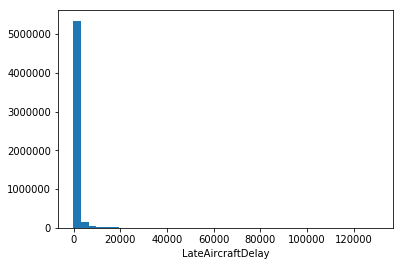

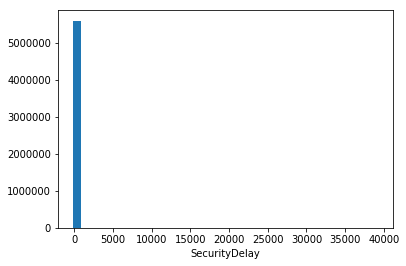

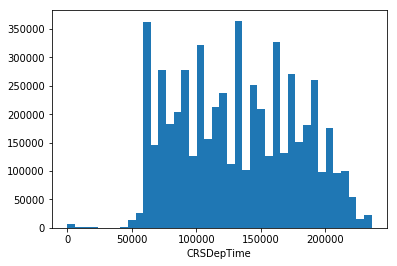

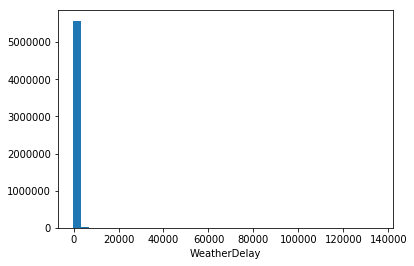

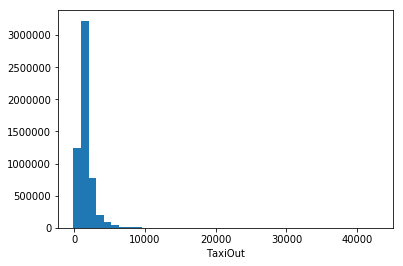

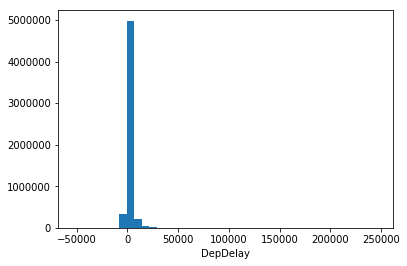

2019-06-02 15:35:43.205064: Function: run_correlation_matrix Begin 
                   LateAircraftDelay  SecurityDelay  CRSDepTime  WeatherDelay  TaxiOut  DepDelay
LateAircraftDelay              1.000          0.191       0.135         0.048    0.066     0.648
SecurityDelay                  0.191          1.000       0.058         0.077    0.142     0.272
CRSDepTime                     0.135          0.058       1.000         0.027    0.035     0.136
WeatherDelay                   0.048          0.077       0.027         1.000    0.093     0.301
TaxiOut                        0.066          0.142       0.035         0.093    1.000     0.108
DepDelay                       0.648          0.272       0.136         0.301    0.108     1.000


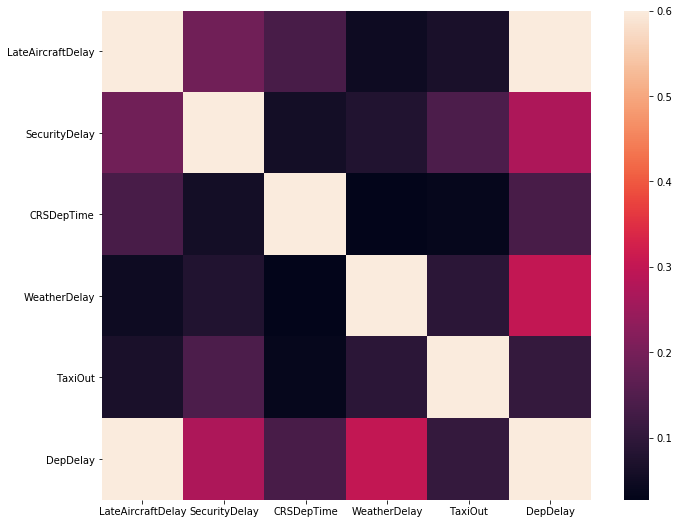

2019-06-02 15:35:44.167433: Function: run_correlation_matrix End 
2019-06-02 15:35:44.167661: Function: run_linear_regression Begin run_linear_regression 
2019-06-02 15:35:44.167703: Function: run_linear_regression Running regr.fit for the training set 

Coeffecients: 
 [ 0.05839647  1.44305452 -0.00147889  0.0940159   0.7247683   0.94561222]

Intercept: 
 -10.083166715716754

R-squared for training data set:
0.910703746254875

R-squared for test data set:
0.9120784033547031
2019-06-02 15:35:45.064715: Function: run_linear_regression End run_linear_regression 


In [219]:
if flag_to_plot_them == True:
    plot_them()
    
if flag_to_run_features_importance == True:
    run_features_imporantance()
    
if flag_to_run_correlation_matrix == True:
    run_correlation_matrix()
    
if flag_to_run_rfc == True:
    run_rfc()
        
if flag_to_run_rfr == True:
    run_rfr()
    
if flag_to_run_gradient_boosting  == True:
    run_gradient_boosting()
    
if flag_to_run_linear_regression  == True:
    run_linear_regression()
    
if flag_to_run_logistic_regression == True:
    run_logistic_regression()
    
if flag_to_run_svc == True:
    run_svc() 